In [1]:
# https://quantumcomputing.stackexchange.com/questions/24050/how-to-implement-a-exponential-of-a-hamiltonian-but-non-unitary-matrix-in-qisk

# control gate: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

# circuit https://www.nature.com/articles/s41598-022-17660-8
import numpy as np

from qiskit.circuit import ControlledGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram

from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator

In [2]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.list_ops import SummedOp
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
A = np.array([
    [11, 5, -1, -1],
    [5, 11, 1, 1],
    [-1, 1, 11, -5],
    [-1, 1, -5, 11],
    ]).astype('complex')

b = np.array([0, 0, 0, 1]).T

In [23]:
def get_gate(A, n):    
    pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
    phi = Parameter('ϕ')
    evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
    trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
    #----control---------
    gate = trotterized_op.to_circuit()
    # print(gate)
    gate.name = f"e^(i*A*pi/{n})"
    gate.label = f"e^(i*A*np.pi/{n})"
    gate = gate.to_gate().control()
    #---------------------
    return gate

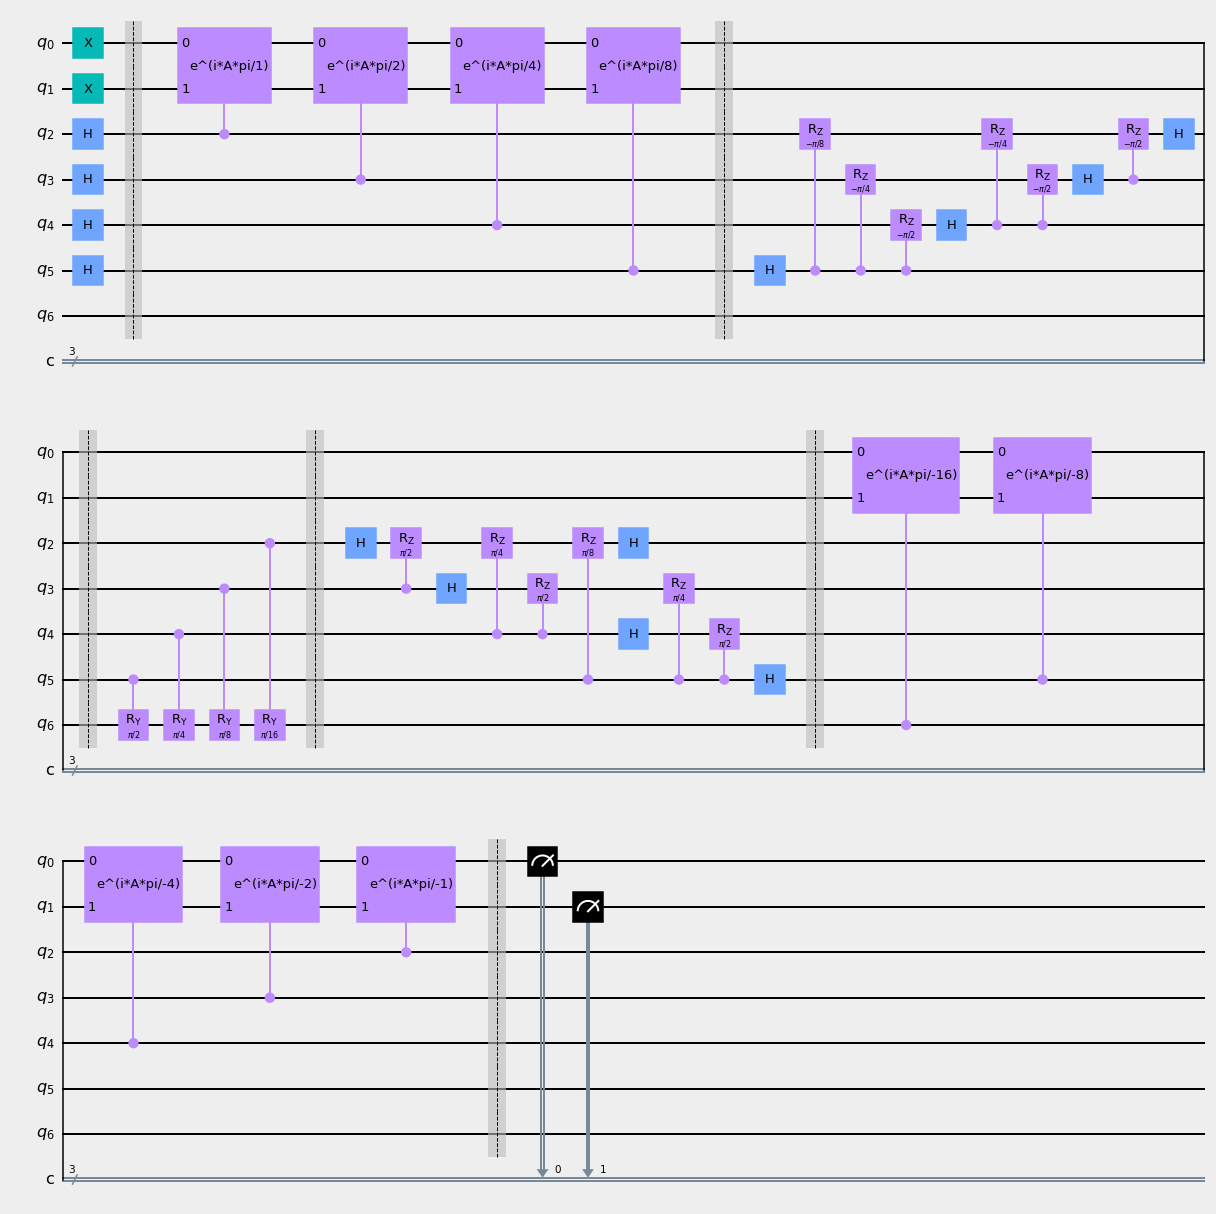

In [159]:
n_b = 2
n_ = 4
n_ancilla = 1
n_cl = 3
# quantum circuit initialization
qc = QuantumCircuit(n_b + n_ + n_ancilla, n_cl)
# b-vector state preparation
for i in range(n_b):
    qc.x(i)
for i in range(n_b, n_b+n_):
    qc.h(i)
qc.barrier()
# Matrix exponentiation
for i in range(1, 5):
    gate = get_gate(A, 2**(i-1))
    qc.append(gate,[i+1, 0, 1])
qc.barrier()
# Phase estimation
for j in range(n_b + n_ - 1, n_b, -1):
    qc.h(j)
    for m in range(j - n_b):
        qc.crz(-np.pi/float(2**(j-m - n_b)), j, m+n_b)
qc.h(j-1)
qc.barrier()
# As I understood, we wncode ancilla qubit to be sure that result will be correct
for j in range(1, 1+n_):
    qc.cry(np.pi/(2**j), n_b+n_-j, n_b+n_)
qc.barrier()
# Inverse quantum Fourier transform
for j in range(n_b, n_b + n_):
    for m in range(j - n_b):
        qc.crz(np.pi/float(2**(j-m - n_b)), j, m+n_b)
    qc.h(j)
qc.h(n_b)
qc.barrier()
# Eigenvalues storing in the vecor b register
for i in range(5, 0, -1):
    gate = get_gate(A, -(2**(i-1)))
    qc.append(gate,[i+1, 0, 1], )
qc.barrier()
# qubits measurement. I do not measure the ancilla qubit
# qc.measure(-1, 2)
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [160]:
simulator = Aer.get_backend('qasm_simulator')
circ = transpile(qc, simulator)
# print(circ)
result = execute(qc, backend=simulator, shots=2048).result()

In [161]:
counts = result.get_counts()
counts

{'011': 1449, '010': 410, '000': 99, '001': 90}

# Calculated result

In [162]:
print(
    (1449/2048),
    (410/2048),
    (99/2048),
    (90/2048)
)

0.70751953125 0.2001953125 0.04833984375 0.0439453125


# Real x-vector result

In [67]:
print(
    'real is',
    1/32,
    -1/32,
    1/16,
    1/8
)

real is 0.03125 -0.03125 0.0625 0.125


# Result x-vector from paper

In [69]:
print(
    np.sqrt(0.0455),
    np.sqrt(0.0455),
    np.sqrt(0.1818),
    np.sqrt(0.7272)
)

0.2133072900770154 0.2133072900770154 0.42638011210655685 0.8527602242131137


In [101]:
0.0455+0.0455+0.1818+0.7272

1.0

# Normalization of real x-vector result

In [106]:
a = [0.03125, -0.03125, 0.0625, 0.125]

from sklearn.preprocessing import normalize
norm1 = np.array(a) / np.linalg.norm(a)
norm1**2

array([0.04545455, 0.04545455, 0.18181818, 0.72727273])